### Code used for reading and converting PCraster files to array and computing monthly streamflow metrics

#### This code is divided in two parts: 

#### (a) The first part provide an automatic read of PCraster files into array, and then organize the data in a time series to be used for further analysis.

The code will read a total of Z .map files, and will reshape each file from a (X, Y) to a (1, X * Y), and will assing each file matrix to a different line. Therefore we will have a time-series matrix of (Z, X * Y) shape. 

Since the full raster matrix is too big, a clone map mask is used to convert just the grids that are from rivers and streams in the map, reducing the number of columns. 

#### (b) Additinally, this code provide the automatic calculation of the Monthly Hydrological Indicators for river streamflow. It follows the methodology proposed by Pumo et al. (2018), which is an addaptation of the methodlogy proposed for daily streamflow by Richter et al. (1996).

In total there are 22 individual indicators, 5 group indices (MI-HRA), and one Global indice (GMI-HRA).

References: Pumo, D., Francipane, A., Cannarozzo, M., Antinoro, C., Noto, L.V., 2018. Monthly hydrological indicators to assess possible alterations on rivers' flow regime. Water Resour. Manag.
32, 3687–3706. https://doi.org/10.1007/s11269-018-2013-6.

Richter, B.D., Baumgartner, J.V., Powell, J., Braun, D.P., 1996. A method for assessing hydrologic alteration within ecosystems. Conserv. Biol. 10, 1163–1174. https://doi.org/10.1046/j.1523-1739.1996.10041163.x.

#### (c) The code also shows the step-by-step about how to perform also the Mann-Kendall and Sen's estimator tests in the dataset.

Reference: Md. Manjurul Hussain Shourov, Ishtiak Mahmud, & Kyle Niemeyer. (2021). mmhs013/pyMannKendall: v1.4.2 (v1.4.2). Zenodo. https://doi.org/10.5281/zenodo.4849563


Developed by: Thiago Victor Medeiros do Nascimento

In [1]:
from pcraster import *
import numpy as np
from osgeo import gdal, gdalconst
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pylab as plt
import subprocess
import glob,os
import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pymannkendall as mk
import tqdm
from tqdm import tqdm

### (a) Reading and converting PCraster files to array:

In [2]:
path =r'D:\pythonDATA\AquadaptTemez\rastermapaccum'
filenames = glob.glob(path + "/*.map")
len(filenames)

1032

In [3]:
# time series matrix 
mapfile = filenames[0]

RasterLayer = gdal.Open(mapfile)

ncols = RasterLayer.RasterXSize
nrows = RasterLayer.RasterYSize

# about 50 arrays
numtotal = nrows*ncols
numtotal

48694800

We cannot process all the data efficiently, and besides we are interested mainly on data in the river cells, therefore we can use a clone map with a filter. This map has 1 as river cells and 0 as non-river cells. Therefore, the processing will be optimizes solely for the river cells. 

In [4]:
pathfilter =r'C:\Users\User\OneDrive\IST\RESEARCH\python\flowindicatorsmap\rivernetworkabove100000mmclipped.map'
#pathfilter =r'C:\Users\User\OneDrive\IST\RESEARCH\python\flowindicatorsmap\rivernetworkabove50000mmclipped2.map'
#pathfilter =r'C:\Users\User\OneDrive\IST\RESEARCH\python\flowindicatorsmap\rivernetworkabove25000mmclipped.map'

#pathfilter =r'C:\Users\User\OneDrive\IST\RESEARCH\python\flowindicatorsmap\rivernetworkabove5000mmclipped.map'

# about 2,300,000 cells for 5,000
# about 1,073,609 cells for 25,000
# about 780,000 cells for 50,000
# about 578,975 cells for 50,000
 
mapfilter = readmap(pathfilter)
Rastermapfilter = gdal.Open(pathfilter)
mapfilterarray = pcr_as_numpy(mapfilter)
mapfilterarray
mapfilterarray[mapfilterarray < 1 ] = np.nan

newnumtotal = np.count_nonzero(~np.isnan(mapfilterarray))

# We need additionally to reshape our filter:
mapfilterarrayres = np.reshape(mapfilterarray, (1, numtotal))
mapfilterarrayres

array([[nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [5]:
print("We initially had a total of:", numtotal, "cells, however only", newnumtotal, "refers indeed for river cells")

We initially had a total of: 48694800 cells, however only 578975 refers indeed for river cells


In [6]:
# We create an array with the total number of non NaNs as columns and the total months as rows:
runofftsarray = np.zeros((len(filenames),newnumtotal),dtype=np.float32)

This loop will read each month (.map file) transform it in a array, and exctract solely the river cells data for our runofftsarray:

In [7]:
start = time.time()
#for mapfile in filenames[0:1]:
for mapfile in tqdm(filenames):
    
    namewithmap = os.path.basename(mapfile)
    namemap = namewithmap.replace("accum.map", "")
    namemap = namemap.replace("T", "")
    
    # The files are not organized in order when they are read, therefore we will make a way to write each line in the correct line of the geral
    namemapint = int(namemap) - 1 
    
     
    mapreadarray = pcr_as_numpy(readmap(mapfile))
    mapreadarrayres = np.reshape(mapreadarray, (1, numtotal))
    
    
    
    runofftsarray[namemapint,:] = mapreadarrayres[~np.isnan(mapfilterarrayres)]
end = time.time()
print(end - start)

100%|██████████████████████████████████████████████████████████████████████████████| 1032/1032 [33:03<00:00,  1.92s/it]

1983.5912086963654


In [8]:
np.max(runofftsarray)

1514561400.0

In [9]:
np.min(runofftsarray)

0.0

Finally, the time-series matrix is saved as a CSV file to be further analysed

In [8]:
np.savetxt(r'D:\pythonDATA\AquadaptTemez\runofftsarray.csv', runofftsarray[:, 0:100], delimiter=',')

In [10]:
#np.savetxt(r'D:\pythonDATA\AquadaptTemez\runofftsarray.csv', runofftsarray, delimiter=',')

As the raster too big, the optimal way to deal with is istead of saving and reading it, just keep working with it in the same script without clean the outputs.

### (b) Individual indicators computation for each statistical group:

At this part we may proceed with the further computations of the monthly indicators

In [5]:
import monthstreamflowindices as monthstreamflowindices
help(monthstreamflowindices)

Help on module monthstreamflowindices:

NAME
    monthstreamflowindices - Created on Fri Feb 24 15:28:19 2023

DESCRIPTION
    @author: Thiago Nascimento
    This code provides the automatic calculation of the Monthly Hydrological Indicators for river streamflow. 
    It follows the methodology proposed by Pumo et al. (2018), which is an addaptation of the methodlogy 
    proposed for daily streamflow by Richter et al. (1996).
    
    In total there are 22 individual indicators, 5 group indices (MI-HRA), and one Global indice (GMI-HRA).
    
    References: 
        
    Pumo, D., Francipane, A., Cannarozzo, M., Antinoro, C., Noto, L.V., 2018. 
    Monthly hydrological indicators to assess possible alterations on rivers' flow regime. 
    Water Resour. Manag. 32, 3687–3706. https://doi.org/10.1007/s11269-018-2013-6.
    
    Richter, B.D., Baumgartner, J.V., Powell, J., Braun, D.P., 1996. 
    A method for assessing hydrologic alteration within ecosystems. 
    Conserv. Biol. 10, 1163

In [18]:
runoffdataarray = pd.read_csv(r'D:\pythonDATA\AquadaptTemez\runofftsarray.csv', header=None)
runofftotal = pd.DataFrame(index = pd.date_range('10-01-1930','09-30-2016', freq='M'), data = runoffdataarray.values, dtype=np.float32)
runofftotal

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1930-10-31,7123.261719,7169.690430,22844.748047,22956.060547,24071.884766,7262.547852,20332.867188,20833.767578,21112.046875,25001.095703,...,18499.705078,59583.792969,61597.406250,61733.992188,62488.046875,57198.746094,7012.675781,21705.648438,6977.208008,6896.691406
1930-11-30,9003.511719,9063.221680,36967.652344,37156.621094,39055.828125,9182.641602,32721.261719,33571.621094,34044.046875,40699.921875,...,32893.519531,104706.421875,108980.671875,109277.070312,96881.445312,88060.664062,8992.295898,27818.402344,9021.970703,8914.746094
1930-12-31,20121.480469,20256.449219,44129.605469,44339.699219,46433.800781,20526.386719,39391.589844,40337.023438,40862.265625,48163.105469,...,35444.742188,114000.843750,117922.984375,118191.250000,294401.718750,256676.031250,21903.113281,63577.304688,20478.898438,20217.320312
1931-01-31,13245.123047,13336.080078,26842.835938,26967.750000,28206.382812,13517.994141,24025.664062,24587.771484,24900.052734,29213.550781,...,21088.957031,67642.453125,69853.664062,70005.312500,208232.781250,177852.562500,14196.315430,42349.847656,13834.306641,13655.259766
1931-02-28,13884.755859,13977.988281,26859.048828,26981.783203,28198.257812,14164.453125,24085.591797,24637.890625,24944.722656,29172.736328,...,20285.765625,65783.046875,67780.210938,67912.960938,204311.546875,170821.765625,15327.756836,43841.023438,14169.881836,13987.938477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31,15538.186523,15643.402344,31630.244141,31784.865234,33325.148438,15853.833984,28155.021484,28850.810547,29237.359375,34627.523438,...,26958.076172,86016.421875,89367.554688,89596.632812,268120.343750,222982.265625,17758.197266,49591.031250,16113.516602,15899.602539
2016-06-30,6130.918457,6172.570312,15349.742188,15424.328125,16162.346680,6255.874023,13676.847656,14012.486328,14198.952148,16784.380859,...,13234.991211,41744.867188,43366.093750,43477.699219,102277.445312,78781.828125,6260.140137,18994.152344,6320.516602,6242.833008
2016-07-31,4028.177246,4055.554199,10053.099609,10101.755859,10582.534180,4110.308105,8961.914062,9180.869141,9302.510742,10986.575195,...,8640.433594,27233.591797,28286.035156,28358.482422,66665.687500,51425.546875,4100.079102,12473.141602,4153.479004,4102.479980
2016-08-31,2572.510498,2589.982422,6563.466309,6595.187012,6908.609375,2624.926270,5851.929688,5994.671387,6073.972168,7171.385254,...,5613.469727,17697.857422,18373.634766,18420.125000,42519.890625,32802.308594,2616.954346,7962.537109,2651.271729,2618.753662


In [10]:
runoffdataarray = runofftsarray

In [15]:
runofftotal = pd.DataFrame(index = pd.date_range('10-01-1930','09-30-2016', freq='M'), data = runoffdataarray, dtype=np.float32)

In [19]:
runofftotal

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1930-10-31,7123.261719,7169.690430,22844.748047,22956.060547,24071.884766,7262.547852,20332.867188,20833.767578,21112.046875,25001.095703,...,18499.705078,59583.792969,61597.406250,61733.992188,62488.046875,57198.746094,7012.675781,21705.648438,6977.208008,6896.691406
1930-11-30,9003.511719,9063.221680,36967.652344,37156.621094,39055.828125,9182.641602,32721.261719,33571.621094,34044.046875,40699.921875,...,32893.519531,104706.421875,108980.671875,109277.070312,96881.445312,88060.664062,8992.295898,27818.402344,9021.970703,8914.746094
1930-12-31,20121.480469,20256.449219,44129.605469,44339.699219,46433.800781,20526.386719,39391.589844,40337.023438,40862.265625,48163.105469,...,35444.742188,114000.843750,117922.984375,118191.250000,294401.718750,256676.031250,21903.113281,63577.304688,20478.898438,20217.320312
1931-01-31,13245.123047,13336.080078,26842.835938,26967.750000,28206.382812,13517.994141,24025.664062,24587.771484,24900.052734,29213.550781,...,21088.957031,67642.453125,69853.664062,70005.312500,208232.781250,177852.562500,14196.315430,42349.847656,13834.306641,13655.259766
1931-02-28,13884.755859,13977.988281,26859.048828,26981.783203,28198.257812,14164.453125,24085.591797,24637.890625,24944.722656,29172.736328,...,20285.765625,65783.046875,67780.210938,67912.960938,204311.546875,170821.765625,15327.756836,43841.023438,14169.881836,13987.938477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31,15538.186523,15643.402344,31630.244141,31784.865234,33325.148438,15853.833984,28155.021484,28850.810547,29237.359375,34627.523438,...,26958.076172,86016.421875,89367.554688,89596.632812,268120.343750,222982.265625,17758.197266,49591.031250,16113.516602,15899.602539
2016-06-30,6130.918457,6172.570312,15349.742188,15424.328125,16162.346680,6255.874023,13676.847656,14012.486328,14198.952148,16784.380859,...,13234.991211,41744.867188,43366.093750,43477.699219,102277.445312,78781.828125,6260.140137,18994.152344,6320.516602,6242.833008
2016-07-31,4028.177246,4055.554199,10053.099609,10101.755859,10582.534180,4110.308105,8961.914062,9180.869141,9302.510742,10986.575195,...,8640.433594,27233.591797,28286.035156,28358.482422,66665.687500,51425.546875,4100.079102,12473.141602,4153.479004,4102.479980
2016-08-31,2572.510498,2589.982422,6563.466309,6595.187012,6908.609375,2624.926270,5851.929688,5994.671387,6073.972168,7171.385254,...,5613.469727,17697.857422,18373.634766,18420.125000,42519.890625,32802.308594,2616.954346,7962.537109,2651.271729,2618.753662


In [20]:
runofftotal["month"] = pd.date_range('10-01-1930','09-30-2016', freq='M').month

Here we split our entire data in "natural" and "modified":

In [21]:
#datanatural = runofftotal.loc['10-01-1934':'10-01-1990']
#datamodified = runofftotal.loc['10-01-1990':'10-01-2016']

datanatural = runofftotal.loc['10-01-1934':'10-01-2000']
datamodified = runofftotal.loc['10-01-2000':'10-01-2016']

In [22]:
datanatural1 = datanatural.iloc[:, 0:10]
datanatural1["month"] = datanatural["month"]

In [23]:
datamodified1 = datamodified.iloc[:, 0:10]
datamodified1["month"] = datamodified["month"]

#### Magnitude timing (Group 1):

At this moment we can call the function "p1s_magnitudetiming" written inside module "monthstreamflowindices".

In [24]:
p1s, MIhra1 = monthstreamflowindices.p1s_magnitudetiming(datanatural =  datanatural1, 
                                                         datamodified = datamodified1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.81it/s]

0.47417306900024414


In [25]:
p1s

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.077087,0.076233,0.000000,0.000000,0.000000,0.074524,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.271240,0.270752,0.584473,0.583984,0.580566,0.270264,0.592773,0.590820,0.589844,0.574707


In [26]:
MIhra1

,MIhra1
0,0.042699
1,0.042567
2,0.058990
3,0.058919
4,0.058278
5,0.042343
6,0.060354
7,0.060028
8,0.059865
9,0.057195


Here we can check our maximum global indice:

Now we save the datasets:

In [40]:
#p1s.T.to_csv(r'D:\pythonDATA\AquadaptTemez\p1s2.csv')

In [41]:
#MIhra1.to_csv(r'D:\pythonDATA\AquadaptTemez\MIhra12.csv')

#### Magnitude duration (Group 2):

At this moment we can call the function "p2s_magnitudeduration" written inside module "monthstreamflowindices".

In [27]:
p2s, MIhra2 = monthstreamflowindices.p2s_magnitudeduration(datanatural =  datanatural1, 
                                                         datamodified = datamodified1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.54it/s]

0.4114551544189453


In [28]:
p2s

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.196899,0.196899,0.197144,0.0,0.196167,0.196289,0.196289,0.196777
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.071106,0.071228,0.073181,0.0,0.066589,0.067566,0.068115,0.075073


In [29]:
MIhra2

,MIhra2
0,0.000000
1,0.000000
2,0.067001
3,0.067032
4,0.067581
5,0.000000
6,0.065689
7,0.065964
8,0.066101
9,0.067963


In [20]:
#p2s.T.to_csv(r'D:\pythonDATA\AquadaptTemez\ps22.csv')

In [21]:
#MIhra2.to_csv(r'D:\pythonDATA\AquadaptTemez\MIhra22.csv')

#### Timing (Group 3):

At this moment we can call the function "p3s_timing" written inside module "monthstreamflowindices".

In [30]:
p3s, MIhra3 = monthstreamflowindices.p3s_timing(datanatural =  datanatural1, 
                                                         datamodified = datamodified1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]

1.0011672973632812


In [31]:
p3s

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
MIhra3

,MIhra3
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [22]:
#p3s.T.to_csv(r'D:\pythonDATA\AquadaptTemez\ps32.csv')

In [23]:
#MIhra3.to_csv(r'D:\pythonDATA\AquadaptTemez\MIhra32.csv')

#### Magnitude frequency (Group 4):

At this moment we can call the function "p4s_magnitudefreq" written inside module "monthstreamflowindices".

In [33]:
p4s, MIhra4 = monthstreamflowindices.p4s_magnitudefreq(datanatural =  datanatural1, 
                                                         datamodified = datamodified1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 77.79it/s]

0.13055109977722168


In [34]:
p4s

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
MIhra4

,MIhra4
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [22]:
#p4s.T.to_csv(r'D:\pythonDATA\AquadaptTemez\ps42.csv')

In [23]:
#MIhra4.to_csv(r'D:\pythonDATA\AquadaptTemez\MIhra42.csv')

#### Frequency rate of change (Group 5):

At this moment we can call the function "p5s_freqrateofchange" written inside module "monthstreamflowindices".

In [36]:
p5s, MIhra5 = monthstreamflowindices.p5s_freqrateofchange(datanatural =  datanatural1, 
                                                         datamodified = datamodified1)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 137.27it/s]

0.07591891288757324


In [37]:
p5s

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
MIhra5

,MIhra5
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [30]:
#p5s.T.to_csv(r'D:\pythonDATA\AquadaptTemez\p5s2.csv')

In [31]:
#MIhra5.to_csv(r'D:\pythonDATA\AquadaptTemez\MIhra52.csv')

#### Concatetanion of all the single indicators in one single table:

In [49]:
ps, MIhra = monthstreamflowindices.summaryindicators(p1s = p1s, p2s = p2s, p3s = p3s, p4s = p4s, p5s = p5s)

In [50]:
ps

,0,1,2,3,4,5,6,7,8,9
p11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
p12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
p13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
p14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
p15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
p16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
p17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
p18,0.077087,0.076233,0.000000,0.000000,0.000000,0.074524,0.000000,0.000000,0.000000,0.000000
p19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
p110,0.271240,0.270752,0.584473,0.583984,0.580566,0.270264,0.592773,0.590820,0.589844,0.574707


#### Concatetanion of all the group indices in one single table:

In [51]:
MIhra

,MI-HRA1,MI-HRA2,MI-HRA3,MI-HRA4,MI-HRA5
0,0.042699,0.000000,0.0,0.0,0.0
1,0.042567,0.000000,0.0,0.0,0.0
2,0.058990,0.067001,0.0,0.0,0.0
3,0.058919,0.067032,0.0,0.0,0.0
4,0.058278,0.067581,0.0,0.0,0.0
5,0.042343,0.000000,0.0,0.0,0.0
6,0.060354,0.065689,0.0,0.0,0.0
7,0.060028,0.065964,0.0,0.0,0.0
8,0.059865,0.066101,0.0,0.0,0.0
9,0.057195,0.067963,0.0,0.0,0.0


### Computation of the Global index (GMI-HRA):

In [55]:
GMIs = monthstreamflowindices.globalmonthlyindex(MIhra = MIhra)
GMIs

,GMI-HRA
0,0.023290
1,0.023218
2,0.044359
3,0.044325
4,0.044076
5,0.023096
6,0.044864
7,0.044736
8,0.044672
9,0.043554


In [15]:
#GMIs.to_csv(r'D:\pythonDATA\AquadaptTemez\GMIs3.csv')

### (c) Mann-Kendal and Sen's estimator tests:

At this part it is possible to perform the trend-tests in all grid-data to check for possible trends in the time-series 

In [81]:
MKSENresults = pd.DataFrame(index = range(numstationsused), columns = ["trend","p","slope" ], data = np.nan)
MKSENresults

,trend,p,slope
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
578970,NaN,NaN,NaN
578971,NaN,NaN,NaN
578972,NaN,NaN,NaN
578973,NaN,NaN,NaN


In [82]:
start = time.time()
#for i in(range(787714,787714)):
#for i in tqdm((range(1))):
for i in tqdm((range(newnumtotal))):
    result = mk.seasonal_test(runofftotal.iloc[:,i], period = 12)
    MKSENresults.iloc[i,0] = result[0]
    MKSENresults.iloc[i,1] = result[2]
    MKSENresults.iloc[i,2] = result[7]

end = time.time()
print(end - start)  

100%|████████████████████████████████████████████████████████████████████████| 578975/578975 [5:46:10<00:00, 27.87it/s]

20770.91344666481


In [83]:
#(newnumtotal/100)*(end - start)/60/60

In [84]:
MKSENresults.to_csv(r'D:\pythonDATA\AquadaptTemez\MKSENresultscsv.csv')

In [ ]:
#np.savetxt(r'D:\pythonDATA\AquadaptTemez\runofftsarray.csv', runofftsarray, delimiter=',')

In [85]:
MKSENresults.tail(20)

,trend,p,slope
578955,decreasing,3.587695e-07,-74.605209
578956,decreasing,1.302281e-10,-258.864081
578957,decreasing,3.711947e-07,-74.658149
578958,decreasing,3.711947e-07,-74.735822
578959,decreasing,3.754279e-07,-74.802257
578960,decreasing,4.063926e-07,-74.614126
578961,decreasing,4.063926e-07,-74.860352
578962,decreasing,4.705586e-07,-75.052748
578963,decreasing,4.652944e-07,-75.483130
578964,decreasing,4.758801e-07,-75.519734


In [86]:
MKSENresults[MKSENresults.iloc[:,2] < 0]

,trend,p,slope
298,no trend,9.647886e-01,-0.948456
318,no trend,8.861299e-01,-3.133341
319,no trend,9.407770e-01,-1.935181
334,no trend,8.759357e-01,-3.344085
359,no trend,8.606833e-01,-3.781207
...,...,...,...
578970,decreasing,4.636354e-10,-258.509243
578971,decreasing,4.636354e-10,-258.527639
578972,decreasing,4.700522e-10,-258.620989
578973,decreasing,4.700522e-10,-258.627680


In [196]:
np.nanmax(MKSENresults.iloc[:,2])

10534.116531165313

<AxesSubplot:>

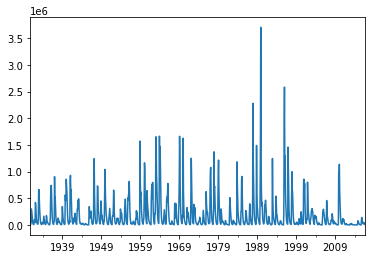

In [166]:
runofftotal.iloc[:,787713].plot()

### (d) Number of months with zero runoff:

At this part we will copute the number of months with zero runoff in our dataset. For starters we will consider as runoff = zero if the runoff in month t is below 0.1% of the average runoff:

In [42]:
# This is an empty table to be filled with the indicators for group 4:
nummonzerrun = pd.DataFrame(index = range(2), columns = range(0,numstationsused), data=np.nan)
nummonzerrun

,0,1,2,3,4,5,6,7,8,9,...,578965,578966,578967,578968,578969,578970,578971,578972,578973,578974
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Creating empty tables for data filling:
condzeronatu = pd.DataFrame(index = datanatural.index, columns = range(1), data=np.nan)
condzeromodi = pd.DataFrame(index = datamodified.index, columns = range(1), data=np.nan)

# Computing the number of months per year:
condzeronatu["datetime"] = condzeronatu.index
condzeromodi["datetime"] = condzeromodi.index

# Computation of water-years:
condzeronatu['year'] = condzeronatu.datetime.dt.year.where(condzeronatu.datetime.dt.month < 10, condzeronatu.datetime.dt.year + 1)
condzeronatu['year'] = condzeronatu['year']

condzeromodi['year'] = condzeromodi.datetime.dt.year.where(condzeromodi.datetime.dt.month < 10, condzeromodi.datetime.dt.year + 1)
condzeromodi['year'] = condzeromodi['year']


condzeronatu.drop(columns=['datetime'], inplace = True) 
condzeromodi.drop(columns=['datetime'], inplace = True) 

In [44]:
# Loop for computing for each station:
start = time.time()

for numstations in tqdm(range(numstationsused)):
#for numstations in range(100):
#for numstations in range(578800, 578974):

    # The median 0.01% is computed:
    #meanstreamflownatu = 0
    #meanstreamflownatu = (datanatural.iloc[:,numstations].mean())*0.01
    meanstreamflownatu = (datanatural.iloc[:,numstations].quantile(q = 0.25))
    condzeronatu.iloc[:,0] = np.where((datanatural.iloc[:,numstations] < meanstreamflownatu),1,0)
    condzeromodi.iloc[:,0] = np.where((datamodified.iloc[:,numstations] < meanstreamflownatu),1,0)
    
    # The total number of low and high pulses are computed for each situation:
    lowpulsesnat = condzeronatu.groupby('year',dropna=False).sum()
    lowpulsesmod = condzeromodi.groupby('year',dropna=False).sum()

    # Computation of the median and quantiles:
    ## First empty data frames for each case are made:
    nummonzerrun.iloc[0,numstations] = lowpulsesnat.median()
    nummonzerrun.iloc[1,numstations] = lowpulsesmod.median()
    
        
end = time.time()
print(end - start) 

100%|█████████████████████████████████████████████████████████████████████████| 578975/578975 [59:42<00:00, 161.59it/s]


3583.0460484027863


In [45]:
np.nanmax(nummonzerrun.iloc[1,:])

11.0

In [46]:
#nummonzerrun.T.tail(50)

In [47]:
nummonzerrun.T.to_csv(r'D:\pythonDATA\AquadaptTemez\nummonzerrunperc25.csv')

In [ ]:
//////////////////////

In [30]:
# This is an empty table to be filled with the indicators for group 4:
nummonzerrun = pd.DataFrame(index = range(2), columns = range(0,numstationsused), data=np.nan)
nummonzerrun

,0,1,2,3,4,5,6,7,8,9,...,578965,578966,578967,578968,578969,578970,578971,578972,578973,578974
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Creating empty tables for data filling:
condzeronatu = pd.DataFrame(index = datanatural.index, columns = range(1), data=np.nan)
condzeromodi = pd.DataFrame(index = datamodified.index, columns = range(1), data=np.nan)

# Computing the number of months per year:
condzeronatu["datetime"] = condzeronatu.index
condzeromodi["datetime"] = condzeromodi.index

# Computation of water-years:
condzeronatu['year'] = condzeronatu.datetime.dt.year.where(condzeronatu.datetime.dt.month < 10, condzeronatu.datetime.dt.year + 1)
condzeronatu['year'] = condzeronatu['year']

condzeromodi['year'] = condzeromodi.datetime.dt.year.where(condzeromodi.datetime.dt.month < 10, condzeromodi.datetime.dt.year + 1)
condzeromodi['year'] = condzeromodi['year']


condzeronatu.drop(columns=['datetime'], inplace = True) 
condzeromodi.drop(columns=['datetime'], inplace = True) 

In [32]:
# Loop for computing for each station:
start = time.time()

for numstations in tqdm(range(numstationsused)):
#for numstations in range(100):
#for numstations in range(578800, 578974):

    # The median 0.01% is computed:
    meanstreamflownatu = (datanatural.iloc[:,numstations].mean())*0.001
    #meanstreamflownatu = (datanatural.iloc[:,numstations].quantile(q = 0.1))
    condzeronatu.iloc[:,0] = np.where((datanatural.iloc[:,numstations] < meanstreamflownatu),1,0)
    condzeromodi.iloc[:,0] = np.where((datamodified.iloc[:,numstations] < meanstreamflownatu),1,0)
    
    # The total number of low and high pulses are computed for each situation:
    lowpulsesnat = condzeronatu.groupby('year',dropna=False).sum()
    lowpulsesmod = condzeromodi.groupby('year',dropna=False).sum()

    # Computation of the median and quantiles:
    ## First empty data frames for each case are made:
    nummonzerrun.iloc[0,numstations] = lowpulsesnat.median()
    nummonzerrun.iloc[1,numstations] = lowpulsesmod.median()
    
        
end = time.time()
print(end - start) 

100%|█████████████████████████████████████████████████████████████████████████| 578975/578975 [51:49<00:00, 186.18it/s]

3109.740616083145


In [33]:
np.nanmax(nummonzerrun.iloc[1,:])

10.0

In [34]:
nummonzerrun.T.to_csv(r'D:\pythonDATA\AquadaptTemez\nummonzerrunzeroonepercent.csv')